## Implementation of DDPG 

Reference Paper

[1] Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D., & Wierstra, D. (2016). Continuous Control with Deep Reinforcement Learning. International Conference on Learning Representations (ICLR) 2016. 

In [58]:
import torch 
import torch.nn as nn
import numpy as np 
import gymnasium as gym
from tqdm import tqdm
import time 
import random
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt

from copy import deepcopy
from utils.replay import ReplayBuffer
from utils.metrics import RollingAverage

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)


In [6]:

test_env = gym.make("Pendulum-v1")
# test_buffer = ReplayBuffer()

# obs, _ = test_env.reset()
# done = False
# for _ in tqdm(range(5000)):
#     action = test_env.action_space.sample()
#     obs_prime, reward, terminated, truncated, _ = test_env.step(action)
    
#     # reward = np.clip(reward, -1, 1)
#     done = terminated or truncated
#     test_buffer.update(obs.squeeze(), action.squeeze(), reward, obs_prime.squeeze(), done)
    
#     obs = obs_prime
#     if done: 
#         obs, _ = test_env.reset()
#         done = False

In [ ]:

class Critic(nn.Module):
    
    def __init__(
        self, 
        env: gym.Env,
        hidden_layers: list = list([400, 300]), 
        *args, 
        **kwargs
    ):
        super(Critic, self).__init__(*args, **kwargs)
        
        self.env = env
        
        self.layers = nn.Sequential(
            nn.Linear(np.prod(self.env.observation_space.shape) + np.prod(self.env.action_space.shape[0]), hidden_layers[0]), # note: this assumes obs spaces of shape (N,) ie 1d
            # nn.LayerNorm(hidden_layers[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_layers[0] , hidden_layers[1]), 
            # nn.LayerNorm(hidden_layers[1]),
            nn.ReLU(),
            
            nn.Linear(hidden_layers[1], 1), 
        )
        
        
        self.layers[0].weight.data = fanin_init(self.layers[0].weight.data.size())
        self.layers[2].weight.data = fanin_init(self.layers[2].weight.data.size())
        self.layers[-1].weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(
        self, 
        obs: torch.Tensor,
        action: torch.Tensor
    ):
        rep_and_act = torch.hstack((obs, action))
        q_val = self.layers(rep_and_act)
        return q_val
    
        


class Actor(nn.Module):
    
    def __init__(
        self, 
        env: gym.Env,
        hidden_layers: list = list([400, 300]),
        sigma: float = 0.2,
        *args, 
        **kwargs
    ):
        super(Actor, self).__init__(*args, **kwargs)
        
        self.env = env
        self.high = self.env.action_space.high[0]
        self.low = self.env.action_space.low[0]
        self.shape = self.env.action_space.shape[0]
        self.scale = sigma
        
        self.layers = nn.Sequential(
            nn.Linear(self.env.observation_space.shape[0], hidden_layers[0]),
            # nn.LayerNorm(hidden_layers[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            # nn.LayerNorm(hidden_layers[1]),
            nn.ReLU(),
            
            nn.Linear(hidden_layers[1], self.shape),
            nn.Tanh(),
        )
        
        self.ounoise = OUActionNoise(mean=np.zeros(1), std_deviation=float(sigma) * np.ones(1))
        
        
        self.layers[0].weight.data = fanin_init(self.layers[0].weight.data.size())
        self.layers[2].weight.data = fanin_init(self.layers[2].weight.data.size())
        self.layers[-2].weight.data.uniform_(-3e-3, 3e-3)
        
        
    def forward(
        self, 
        obs: torch.Tensor,
    ): 
        out = self.layers(obs) # between [-1, 1]
        out = self.high * out
        return out
    
    def sample_actions(
        self, 
        obs: torch.Tensor,
    ): 
        self.eval()
        with torch.no_grad():
            actions = self(obs)
            out = actions.cpu().detach().numpy() + np.random.normal(scale=self.scale * self.high, size=self.shape) 
            out = out.clip(self.low, self.high).reshape(self.shape)
        self.train()
        return out
    
class DDPGAgent:
    
    def __init__(
        self,
        env: gym.Env, 
        tau: float = 0.001,
        lr_actor: float = 0.0001,
        lr_critic: float = 0.001, 
        wd: float = 0.0,
        device: str = 'cpu',
        ou_sigma: float = 0.1, 
        gamma: float = 0.99, 
        capacity: int = 100000, 
    ):
        self.actor = Actor(env, sigma=ou_sigma).to(device)
        self.critic = Critic(env).to(device)
    
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_critic, weight_decay=wd)
        
        self.actor_target = deepcopy(self.actor)
        self.critic_target = deepcopy(self.critic)
        
        self.gamma = gamma
        self.env = env
        self.tau = tau
        self.device = device
        self.buffer = ReplayBuffer(self.env.observation_space.shape[0], 
                                   self.env.action_space.shape[0], capacity, self.device)
        
        
    def update(
        self,
        batch_size: int = 32
    ): 
        batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones = self.buffer.sample(
                batch_size)
        with torch.no_grad():
            target_actions = self.actor_target(batch_next_obs)
            q_targets = self.critic_target(batch_next_obs, target_actions)
            td_target = batch_rewards + self.gamma * q_targets * (1 - batch_dones.float())
            
           
        q_values = self.critic(batch_obs, batch_actions) 
        loss_critic = F.mse_loss(q_values, td_target)
        
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        self.critic_optimizer.step()
        
        loss_actor = -self.critic(batch_obs, self.actor(batch_obs)).mean()
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()
        
        return loss_critic
    
    def soft_update(self):
        # soft target update 
        with torch.no_grad():
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)
            
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data) 

In [ ]:

def train(
    env: gym.Env,
    agent: DDPGAgent, 
    game_name: str, 
    batch_size: int = 32, 
    timesteps: int = 1000000,
    preload: int = 100,    
    window: int = 20,
    val_freq: int = 10000, 
    num_val_eps: int = 2, 
    device: str = 'cpu',
    save_step: int = 850000,
    update_freq: int = 10, 
    seed: int = 0
):
    # setup
    metrics = RollingAverage(window_size=window)
    
    val_env = deepcopy(env)
    best_reward = float('-inf')
    
    # preload the env
    obs, _ = env.reset(seed=seed)
    done = False
    for _ in tqdm(range(preload)):
        action = env.action_space.sample()
        obs_prime, reward, terminated, truncated, _ = env.step(action)
        
        # reward = np.clip(reward, -1, 1)
        done = terminated or truncated
        agent.buffer.update(obs.squeeze(), action, reward, obs_prime.squeeze(), done)
        
        obs = obs_prime
        if done: 
            obs, _ = env.reset()
            done = False
    
    obs, _ = env.reset(seed=seed)
    done = False
    # actual training loop 
    for step in range(1, timesteps):
        start_time = time.time()

        sampled_action = agent.actor.sample_actions(torch.as_tensor(obs, dtype=torch.float32, device=device).view(1, -1))
        obs_prime, reward, terminated, truncated, _ = env.step(sampled_action)
        
        # reward = np.clip(reward, -1, 1)
        done = terminated or truncated
        agent.buffer.update(obs.squeeze(), sampled_action, reward, obs_prime.squeeze(), done)
        
        obs = obs_prime
        if done:
            obs, _ = env.reset(seed=seed)
            done = False
        
        if step % update_freq == 0:
            loss = agent.update(batch_size)
            agent.soft_update()                
            time_per_step = time.time() - start_time
            
        # val loop 
        if step % val_freq == 0:
            for _ in range(num_val_eps):
                obs_val, _ = val_env.reset()
                done_val = False
                ep_reward = 0 
                while not done_val:
                    with torch.no_grad():
                        action = agent.actor(torch.as_tensor(obs_val, dtype=torch.float32,
                                                       device=device).view(1, -1)).cpu().detach().numpy() 
                        action = action.reshape(env.action_space.shape[0])
                        
                    obs_prime_val, reward_val, terminated, truncated, _ = val_env.step(action)
                    ep_reward += reward_val
                    
                    obs_val = obs_prime_val
                    done_val = terminated or truncated
                    
                metrics.update(ep_reward)                            
            
            if step > save_step and metrics.get_average > best_reward:

                torch.save({
                    'actor_state_dict' : agent.actor.state_dict(),
                    'critic_state_dict' : agent.critic.state_dict()
                }, f'../models/DDPG_{game_name.upper()}.pt')
                
                best_reward = metrics.get_average
                
        print(f'Step {step} | Average Val Reward: {metrics.get_average:.4f} | Loss Critic: {loss:.4f} | Time per step {time_per_step:.5f}', end='\r')
        
    env.close()
    val_env.close()
    return metrics

In [ ]:
# this is without layernorm
env = gym.make('Pendulum-v1')
agent = DDPGAgent(env,
                  tau=0.005, 
                  lr_critic=1e-4,
                  lr_actor=1e-4,
                  ou_sigma=0.1,
                  capacity=500000,
                  wd=0.01, 
                  device=device)

metrics = train(env, 
                agent, 
                'Pendulum', 
                timesteps=50000,
                val_freq=2000, 
                num_val_eps=20,
                device=device, 
                batch_size=128,
                preload=50000, 
                update_freq=1,
                save_step=40000,
                seed=seed)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:30<00:00, 1631.36it/s]


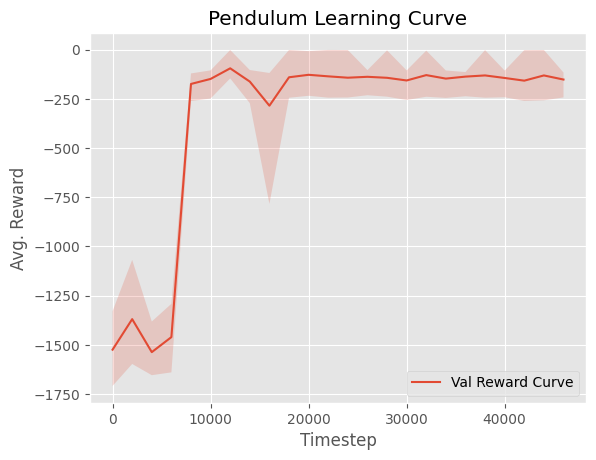

In [66]:
data = np.zeros(((50000 // 2000)-1, 20))

pointer = 0
for i in range(len(data)):
    data[i, :] = metrics.all_rewards[pointer:pointer+20]
    pointer += 20
    
    
q = 10 
high_vars = []
low_vars = []
for i in range(len(data)):
    low_vars.append(np.percentile(data[i, :], q=q))
    high_vars.append(np.percentile(data[i, :], q=100-q))

    
plt.style.use('ggplot')
plt.title('Pendulum Learning Curve')
plt.xlabel('Timestep')
plt.ylabel('Avg. Reward')
plt.fill_between(np.arange(0, 48000, 2000), low_vars, high_vars, alpha=0.2)
plt.plot(np.arange(0, 48000, 2000), data.mean(axis=-1), label='Val Reward Curve')
plt.legend();

In [100]:
env_inv = gym.make('InvertedPendulum-v5')
agent_inv = DDPGAgent(env_inv,
                  tau=0.005, 
                  lr_critic=1e-3,
                  lr_actor=1e-3,
                  ou_sigma=0.2,
                  capacity=50000,
                  wd=0.01, 
                  device=device)

metrics_inv = train(env_inv, 
                agent_inv, 
                'InvertedPendulum', 
                timesteps=50000,
                val_freq=2000, 
                num_val_eps=20,
                device=device, 
                batch_size=128,
                preload=20000, 
                update_freq=1,
                save_step=900000,
                seed=seed)

100%|██████████| 20000/20000 [00:08<00:00, 2332.03it/s]


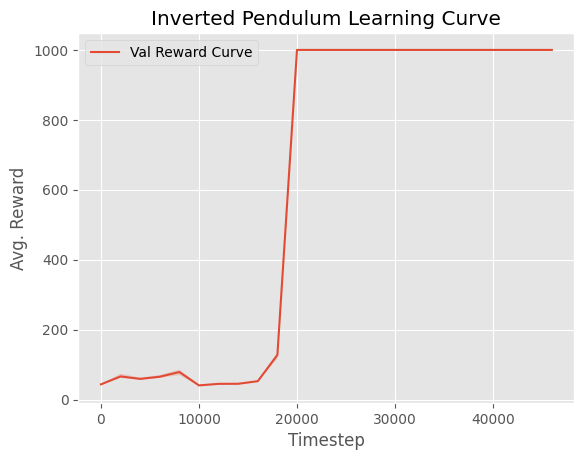

In [106]:
data = np.zeros(((50000 // 2000)-1, 20))

pointer = 0
for i in range(len(data)):
    data[i, :] = metrics_inv.all_rewards[pointer:pointer+20]
    pointer += 20
    
    
q = 5 
high_vars = []
low_vars = []
for i in range(len(data)):
    low_vars.append(np.percentile(data[i, :], q=q))
    high_vars.append(np.percentile(data[i, :], q=100-q))

    
plt.style.use('ggplot')
plt.title('Inverted Pendulum Learning Curve')
plt.xlabel('Timestep')
plt.ylabel('Avg. Reward')
plt.fill_between(np.arange(0, 48000, 2000), low_vars, high_vars, alpha=0.2)
plt.plot(np.arange(0, 48000, 2000), data.mean(axis=-1), label='Val Reward Curve')
plt.legend();

In [108]:
test_env = gym.make('Pendulum-v1', render_mode='human')
for _ in range(5):
    obs, _ = test_env.reset()
    done = False
    ep_reward = 0 
    while not done: 
        action = agent.actor(torch.as_tensor(obs, dtype=torch.float32,
                                                       device=device).view(1, -1)).cpu().detach().numpy() 
        action = action.reshape(test_env.action_space.shape[0])
        # print(f'{action} | {reward}', end='\r')
        
        obs_prime, reward, terminated, truncated, _ = test_env.step(action)
        ep_reward += reward
        
        obs = obs_prime
        done = terminated or truncated
        
    print(ep_reward)
test_env.close()

-238.5636862773128
-127.35931491883551
-120.77810256844558
-123.91787931972348
-128.6557591325106


In [109]:
test_env = gym.make('InvertedPendulum-v5', render_mode='human')
for _ in range(5):
    obs, _ = test_env.reset()
    done = False
    ep_reward = 0 
    while not done: 
        action = agent_inv.actor(torch.as_tensor(obs, dtype=torch.float32,
                                                       device=device).view(1, -1)).cpu().detach().numpy() 
        action = action.reshape(test_env.action_space.shape[0])
        # print(f'{action} | {reward}', end='\r')
        
        obs_prime, reward, terminated, truncated, _ = test_env.step(action)
        ep_reward += reward
        
        obs = obs_prime
        done = terminated or truncated
        
    print(ep_reward)
test_env.close()

1000
1000
1000
1000
1000
